![](http://ml.xiniuedu.com/fastai1.png)
##### 版权归 **©大数据文摘** 所有  保留所有权利

## Lesson3_Image segmentation with CamVid
## 构造对于CamVid街景数据集的图像分割模型

##### 作者：@土豆  @寒小阳    |   [大数据文摘](http://www.bigdatadigest.cn/#/courseDetail?course_id=30&S=123) X POWERED BY[稀牛学院](http://www.xiniuedu.com)

>本课程为fast.ai《深度学习实战》的配套实训课程，为学员提供专属在线实训环境、足量GPU资源、运行不报错的代码和对案例的深度解析。
>本课程旨在帮助学员快速拥有可直接使用的实训环境，一键开启，顺利运行所有代码，扫除软件安装障碍、环境搭建障碍和代码调试障碍，直接进入核心内容的学习环节。

>课程学习资料:
- 英文版视频课程网站：[fast.ai Practical Deep Learning for Coders, v3](https://course.fast.ai/)
- 中文版视频课程链接：[fast.ai深度学习实战课](https://study.163.com/course/introduction/1209462827.htm)
- 配套的实训课程链接：[fast.ai深度学习实战课 - 配套实训](http://www.bigdatadigest.cn/#/courseDetail?course_id=30&S=i)
- GitHub：[theBigDataDigest](https://github.com/theBigDataDigest)
- B站：[大数据文摘编辑部](https://space.bilibili.com/284912325)

>**温馨提示**：
请不要在课程环境中运行个人工业级项目或进行长时间的训练，以免占用过多资源，影响他人学习。触发警报会造成训练中断或数据丢失，请您注意。感谢您的配合！

In [1]:
# 三行”套路“代码，含义是当导入的库发生改变时，自动重新加载；图片绘制在本notebook文件中。
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# 导出本次课程需要的库
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

在上一节课中，我们是在 Tiramisu-CamVid 数据集上进行训练的，有一些缺陷，主要是那些图像都非常单一：全部图像都是汽车的路拍。自动驾驶或许是有些作用的，但若从那样的数据集中进行学习一般意义上的图像分割任务来说就毫无益处。所以，在本次课程中，我们将会使用完整的 CamVid 数据集合，详情可见[这里](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/)。

我们已经将这套数据集提前内置在了此实验平台上，方便大家快速读取和实验哈！

In [3]:
# 查看数据文件目录
!ls ../data/FASTAI/camvid/

codes.txt  images  labels  valid.txt


In [4]:
# 全局定义图片和标签的路径
path = Path('../data/FASTAI/camvid/')
path_lbl = path/'labels'
path_img = path/'images'

## Data 数据

首先我们来瞅一眼数据是怎样的：

In [5]:
# 获取所有图片数据的路径，并显示前三条路径
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('../data/FASTAI/camvid/images/0001TP_006690.png'),
 PosixPath('../data/FASTAI/camvid/images/0001TP_006720.png'),
 PosixPath('../data/FASTAI/camvid/images/0001TP_006750.png')]

In [6]:
# 获取所有图片标签的路径，并显示前三条路径
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('../data/FASTAI/camvid/labels/0001TP_006690_P.png'),
 PosixPath('../data/FASTAI/camvid/labels/0001TP_006720_P.png'),
 PosixPath('../data/FASTAI/camvid/labels/0001TP_006750_P.png')]

可以看到图片和标签的文件名字之间是有着相类似编码信息。

我们要想办法把每张图片与对应的标签联系起来。

In [7]:
# images 与 labels 两个文件夹中必然有着相同的文件数目
assert len(fnames) == len(lbl_names) == 701

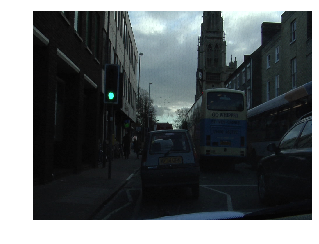

In [8]:
# 打印第一张图片瞅一眼
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
img_f

PosixPath('../data/FASTAI/camvid/images/0001TP_006690.png')

In [10]:
img_f.stem, img_f.suffix

('0001TP_006690', '.png')

In [11]:
# 定义 get_y_fn 函数，使得输入一个图片文件路径，就可以输出对应的标签文件的路径
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

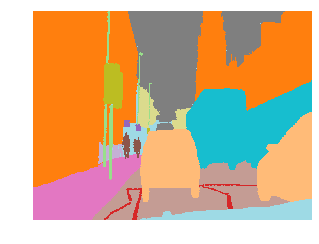

In [12]:
# 瞅一眼像素级别的标签是不是和上面👆那张图一样呢？
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:

# 最后我们要再仔细的瞅一眼标签数据的结构，可以看到图片明显比上节课要大一些。
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [14]:
# 此外这套数据集的标签也是更多啊！还不快数数有多少个。。。。
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets 数据集

接下来，我们就要构建训练数据集。

首先，我们要考察一下手头剩余显存量究竟够不够你嗨。

- 如果RAM 内存容量大于 8200，batch_size设置为 4。
- 如果 RAM 内容容量小于或等于 8200，batch_size设置为 2。

In [15]:
# 取图片的 1/4 大小为有效训练窗口。
size = src_size//2

free = gpu_mem_get_free_no_cache()  # 获取剩余显存容量
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 9417MB of GPU RAM free


In [16]:
# 根据文件夹的名称来划分寻训练和验证集。这两个数据集都是要用label的。
src = (SegmentationItemList.from_folder(path_img)   # 指定文件夹路径为 path_img
       .split_by_fname_file('../valid.txt')         # 指定标签的位置
       .label_from_func(get_y_fn, classes=codes))   # 通过解析路径地址来获取标签信息

In [17]:
# 根据 get_transforms 函数的默认参数进行数据增强
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)   # 指定 batchsize
        .normalize(imagenet_stats))        # 因之后要使用预训练模型，所以指定 imagenet_stats 

关于 imagenet_stats 可参考[此贴](https://forums.fast.ai/t/calculating-our-own-image-stats-imagenet-stats-cifar-stats-etc/40355).

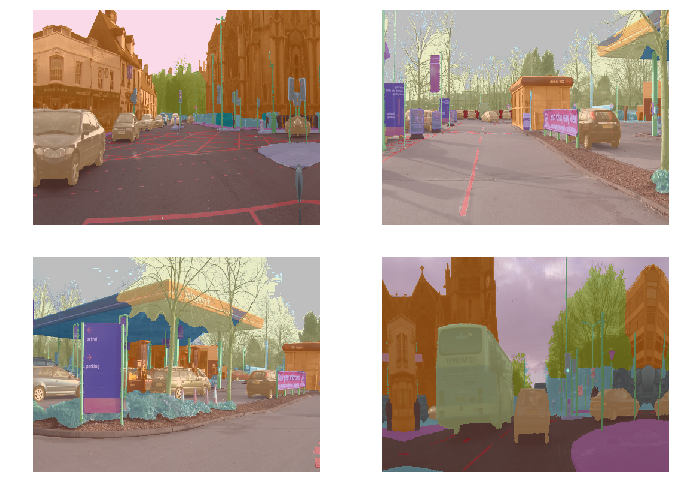

In [18]:
# 我们来看一下目前训练数据的状态。打印两行：
data.show_batch(2, figsize=(10,7))

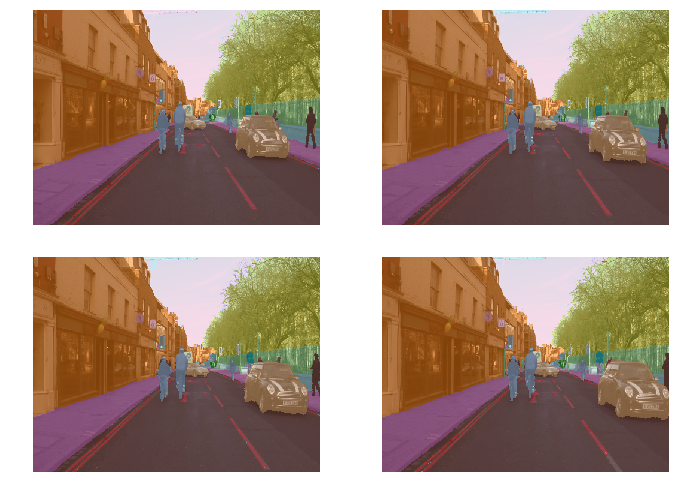

In [19]:
# 我们来看一下目前 Valid 数据的状态。打印两行：
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model 模型

接下来，我们就要构建模型了！

首先先对我们的标签进行数字化，构建了一个叫做 name2id 的字典来保存。并且，我们单独要把 “其他”（“Void”）这个类别的数字标签单独全局定义出来。

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_camvid
# metrics=accuracy

In [22]:
wd=1e-2

In [23]:
# 接下来，我们把刚刚定义的数据、模型放到一起，并指定度量方法（metrics）
# 如果是第一次执行该指令，程序将会从 download.pytorch.org/models 中现在预训练的 resnet34 模型 我们已经下载，用cp复制命令就行了。
!mkdir -p /root/.cache/torch/checkpoints/
!cp /data/FASTAI/resnet34-333f7ec4.pth /root/.cache/torch/checkpoints/
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.model_dir='/notebooks'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


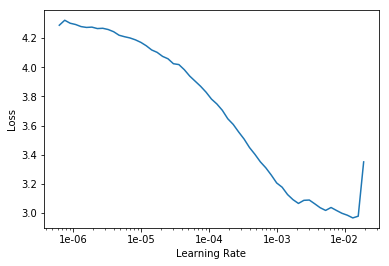

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
# 从图上挑选出表现优异的学习率
lr=3e-3

In [26]:
# 下面根据挑出的学习率，再进一步微调我们的模型 10 遍
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
# 其中 pct_start 参数是一个 0~1 的数，表示学习率在一个 epoch 中什么位置还是提升，
# 可参考：https://forums.fast.ai/t/what-is-the-pct-start-mean/26168

epoch,train_loss,valid_loss,acc_camvid,time
0,0.946058,0.720785,0.830405,03:59
1,0.757330,0.635162,0.838714,04:14
2,0.632059,0.530736,0.855198,04:16
3,0.622652,0.483925,0.866717,04:18
4,0.597888,0.449281,0.880269,02:45
5,0.589187,0.430351,0.885258,02:10
6,0.595581,0.439302,0.877638,02:10
7,0.554722,0.443572,0.874930,02:09
8,0.512810,0.391294,0.885402,02:09
9,0.411002,0.324220,0.903405,02:09


不出意外的话，可以看到训练/测试集的 loss 在每一次迭代时都会越来越小，acc 准确率会越来越高。

In [27]:
# 我们不妨将第一次微调保存下来。
learn.save('stage-1')

In [28]:
# 再读取刚保存的模型。
learn.load('stage-1');

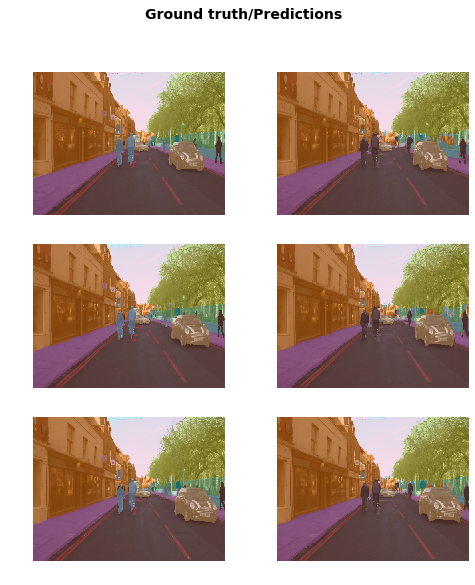

In [29]:
# 打印三行图像看看模型的效果
learn.show_results(rows=3, figsize=(8,9))

可以看到左右图之间大体上都预测准确了，除了一些小的细节依旧需要进一步提高模型表现。

In [30]:
learn.unfreeze() # 模型参数都可迭代更新

In [31]:
# 用更小的学习率来训练
lrs = slice(lr/400,lr/4)

In [32]:
# 第二次微调 12 遍模型
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.379613,0.309734,0.906082,02:14
1,0.366028,0.310982,0.908436,02:14
2,0.356108,0.299880,0.916417,02:39
3,0.344273,0.299731,0.912746,02:14
4,0.343317,0.298743,0.916089,02:14
5,0.346344,0.302149,0.919065,02:15
6,0.324816,0.303871,0.915779,02:15
7,0.342544,0.303721,0.921008,02:14
8,0.315642,0.300694,0.913514,02:14
9,0.302566,0.289747,0.919511,02:15


In [33]:
# 保存第二次微调的模型
learn.save('stage-2');

## Go big 用更大的数据集进行训练

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.<br>
如果内存不够的话，你可能需要重启你的计算内核，然后再返回这一步，同时可能要减少 `bs` 的设定。

In [39]:
# 清空内存缓存。这一句类似于 del learn; gc.collect(); 详情可见：https://docs.fast.ai/tutorial.resources.html#learner-release
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache() # 获取剩余显存容量
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 10944MB of GPU RAM free


In [40]:
# 根据 get_transforms 函数的默认参数进行数据增强
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs,  num_workers=0)  # 指定 batchsize
        .normalize(imagenet_stats))        # 因之后要使用预训练模型，所以指定 imagenet_stats 

In [44]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [45]:
# 载入第二次微调后的模型参数
learn.load('stage-2');

FileNotFoundError: [Errno 2] No such file or directory: '../data/FASTAI/camvid/images/models/stage-2.pth'

In [ ]:
# 训练
lr_find(learn)
learn.recorder.plot()

In [ ]:
# 挑一个顺眼的学习率吧！
lr=1e-3

In [ ]:
# 废话不多说，再给我来 10 轮训练！
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
# 保存这个巨型数据训练下的模型参数
learn.save('stage-1-big')

In [ ]:
# 载入刚刚保存的模型菜蔬
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()  # 模型参数都可迭代更新

In [ ]:
# 用更小的学习率
lrs = slice(1e-6,lr/10)

In [ ]:
# 再给我来 10 轮训练！
learn.fit_one_cycle(10, lrs)

In [ ]:
# 保存这个巨型训练量下的第二次微调的模型参数
learn.save('stage-2-big')

In [38]:
# 载入这个刚刚保存的模型参数
learn.load('stage-2-big');

FileNotFoundError: [Errno 2] No such file or directory: '../data/FASTAI/camvid/images/models/stage-2-big.pth'

In [ ]:
# 打印三行图像数据看看效果！
learn.show_results(rows=3, figsize=(10,10))

目测训练效果相当好哈~ 细节捕捉的也很不错！

#### 恭喜完成所有练习！现在你已经掌握了在线实训平台的基本操作，可以开始正式进入实训课程的学习啦！

> <img src="http://ml.xiniuedu.com/theaicorner.jpg" width=150 height=150 /> ID：theaicorner

>扫描二维码，获取**课程更新** 提醒和Code First系列**新课上线**通知

##### 版权归 **© 大数据文摘** 所有  保留所有权利